# Loan status prediction 
##### This dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/bhavikjikadara/loan-status-prediction)
For further detail refer to *descriptive_analysis.ipynb* or *pre_modelling_process.ipynb* notebooks

In [1]:
import sys
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The following process was conducted carefully in *pre_modelling_process.ipynb* notebook and enhanced in the current one. Refer to the former for further detail

In [2]:
# Load the imputed data
df = pd.read_csv("input/loan_data_imp.csv") 
####################################################################################################
# Recode variables:
df['Married'] = df['Married'].replace({'Yes': 1, 'No': 0})
df['Education'] = df['Education'].replace({'Graduate': 1, 'Not Graduate': 0})
df['Self_Employed'] = df['Married'].replace({'Yes': 1, 'No': 0})
df['Loan_Status'] = df['Loan_Status'].replace({'Y': 1, 'N': 0})

df2 = df.copy()
####################################################################################################
# Import methods to transform categorical features 
# Many methods do not work with object/string type features and thus these must be recoded
from sklearn.compose import ColumnTransformer
# Categorical features will be recoded using an ordinal encoder for further sequential feature selection
from sklearn.preprocessing import OneHotEncoder

numerical_features = ['LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome', 'CoapplicantIncome']
columns_to_keep_same = []
columns_to_keep_same.extend(numerical_features)
columns_to_keep_same.extend(['Loan_ID'])
columns_to_keep_same.extend(['Loan_Status'])

categorical_features = df.columns.difference(columns_to_keep_same).tolist()

# Create a ColumnTransformer to apply one-hot encoding to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'  # Pass through numerical features without any transformation
)

# The preprocessor will return the transformed data with a different column order from the original df
# Later I will turn the np.array into a pd.DataFrame and for that I need the right column order
import re
# First get the feature names ordered from the preprocessor
preprocessor_feature_names = preprocessor.fit(df).get_feature_names_out()

# Clean the "cat__" and "remainder__" prefixes
cleaned_feature_names = [re.sub(r'^(cat__|remainder__)', '', name) for name in preprocessor_feature_names]

# Transform the data
df = preprocessor.fit_transform(df)
df = pd.DataFrame(df, columns = cleaned_feature_names)


####################################################################################################
# Import the train_test_split function from the model_selection module
from sklearn.model_selection import train_test_split

df.sample(frac = 1, random_state = 25).reset_index(drop = True)
df.drop('Loan_ID', inplace = True, axis = 1)

for column in df.columns.tolist():
    df[column] = pd.to_numeric(df[column])

# Split approved loan data
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Loan_Status'], axis = 1), df['Loan_Status'], 
                                                    test_size = 0.2, random_state = 25, stratify = df['Loan_Status']) 
# with stratify = df['Loan_Status'] assures that we keep 71% approved and 29% rejected for both train and test sets

####################################################################################################
# Normalise numeric features

# For this purpose we first need to split into train and test data and normalise them separately
# given that the test data has not been observed yet (data leakage)

# Import the MinMaxScaler from the preprocessing module of sklearn
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()

X_n_train = scaler.fit_transform(X_train)
X_n_test = scaler.fit_transform(X_test)

####################################################################################################
# Lastly, recode the response 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

####################################################################################################
# Create subset of features according to the results Feature Importance Analysis

# X_train_sub = X_train.drop(['Education', 'Married', 'Gender', 'Self_Employed'], axis = 1)
# X_test_sub = X_test.drop(['Education', 'Married', 'Gender', 'Self_Employed'], axis = 1)

# X_n_train_sub = X_n_train.drop(['Education', 'Married', 'Gender', 'Self_Employed'], axis = 1)
# X_n_test_sub = X_n_test.drop(['Education', 'Married', 'Gender', 'Self_Employed'], axis = 1)

## Model fitting process (part 1)

### 1. Logistic Regression
When using logistic regression models, we must use the normalised/standardise features

In [3]:
# Import module with model
from sklearn.linear_model import LogisticRegression

# Import methods to test model's perfrormance
from sklearn.metrics import classification_report, confusion_matrix

# Import method for cross validation and hyperparameter tunning 
from sklearn.model_selection import cross_val_score, GridSearchCV

In [4]:
# Load the Logistic Regression model
logreg = LogisticRegression(random_state = 25)

In [5]:
# Fit the model including all features
logreg.fit(X = X_n_train, y = y_train)
print(logreg.score(X_n_test, y_test))

0.8051948051948052


In [6]:
# Fit the model using cross-validation
print(cross_val_score(logreg, X_n_train, y_train, cv = 25).mean())

0.8548717948717949


In [7]:
# Now let's aim for hyperparameter tunning
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

weights = np.linspace(0.05, 1, 10)
# solver = "liblinear" works fine for small datasets such as the current
pipe = Pipeline([("classifier", LogisticRegression(random_state = 25))])

# solver = "liblinear" works fine for small datasets such as the current

search_space = [
    {"classifier" : [LogisticRegression(random_state = 25)],#solver = "liblinear"
     #classifier__penalty" : ["l1", "l2"],
     #"classifier__class_weight" : [{0:x, 1:1-x} for x in weights],
     "classifier__max_iter" : [500, 1000],
     "classifier__C" : [0.001, 0.1, 1, 2, 10, 25, 50, 100, 250, 500, 1000]
    }
]

#scorer = make_scorer(precision_score, response_method = 'predict')

clf_logreg = GridSearchCV(pipe, search_space, cv = 10, verbose = 3, n_jobs = -1, scoring = 'roc_auc')

In [8]:
clf_logreg.fit(X_n_train, y_train)
print(clf_logreg.best_estimator_.get_params()["classifier"])

Fitting 10 folds for each of 22 candidates, totalling 220 fits
LogisticRegression(C=1, max_iter=500, random_state=25)


In [9]:
clf_logreg.best_score_

0.8250330687830688

In [10]:
logreg_best = LogisticRegression(random_state = 25, C = 1, max_iter = 500)#, class_weight = {0: 0.68, 1: 0.32})
logreg_best.fit(X_n_train, y_train)

print(logreg_best.score(X_n_test, y_test))

0.8051948051948052


After testing the sets of hyperparameters above, the conclusion is that the best hyperparameters for a logistic regression model with C = 0.1, that is quite a strong regularization. A top of 500 iterations was enough, meaning that we did not get any issues with convergence (as expected given the dataset size and the number of features included in the model).

#### Model evaluation
In this stage we will evaluate the model's performance through different measures and indicators that quantify the predictive capabilities of the model.

- Confusion Matrix: The confusion matrix presents a tabular summary of the model's performance by comparing predicted class labels with the true class labels. It consists of four terms:
    - True Positive (TP): The model predicted the positive class correctly.
    - True Negative (TN): The model predicted the negative class correctly.
    - False Positive (FP): The model predicted the positive class incorrectly.
    - False Negative (FN): The model predicted the negative class incorrectly.

- Accuracy: Accuracy is the most commonly used metric, representing the overall correctness of the model's predictions. It is calculated as (TP + TN) / (TP + TN + FP + FN).

- Precision: Precision measures the model's ability to correctly predict the positive class. It is calculated as TP / (TP + FP). Precision is useful when the cost of false positives is high.

- Recall (Sensitivity/True Positive Rate): Recall quantifies the model's ability to correctly identify the positive class instances. It is calculated as TP / (TP + FN). Recall is important when the cost of false negatives is high.

- Specificity: Specificity measures the model's ability to correctly identify the negative class instances. It is calculated as TN / (TN + FP). Specificity is important when the cost of false positives is high.

- F1 Score: The F1 score combines precision and recall into a single metric. It is the harmonic mean of precision and recall and provides a balanced measure. The F1 score is calculated as 2 * (Precision * Recall) / (Precision + Recall).

Additionaly we will explore different probability thresholds that result in more adecuate outcomes for the business, i.e. that the false positive are very low, if not null. Recall that it is very important to avoid approving loans to people who will not be able to pay them. That would result in major losses for the company.
Scikit-learn uses the probability threshold as P>=0.5

In [11]:
# Make predictions on the test set
y_pred = logreg_best.predict(X_n_test)
y_prob = logreg_best.predict_proba(X_n_test)#[:, 1]

In [12]:
logreg_precision_score = precision_score(y_test, y_pred)
logreg_recall_score = recall_score(y_test, y_pred)
logreg_roc_auc_score = roc_auc_score(y_test, y_pred)
logreg_f1_score = f1_score(y_test, y_pred)

print('Logistic regression presicion score: ' + str(round(logreg_precision_score,3)))
print('Logistic regression recall score: ' + str(round(logreg_recall_score,3)))
print('Logistic regression ROC score: ' + str(round(logreg_roc_auc_score,3)))
print('Logistic regression F1 score: ' + str(round(logreg_f1_score,3)))

Logistic regression presicion score: 0.794
Logistic regression recall score: 0.982
Logistic regression ROC score: 0.673
Logistic regression F1 score: 0.878


(0.0, 1.0)

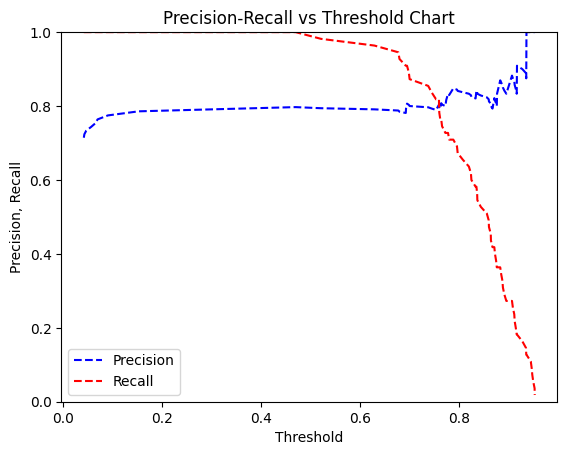

In [13]:
# Precision-Recall vs Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_prob [:,1]) 

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

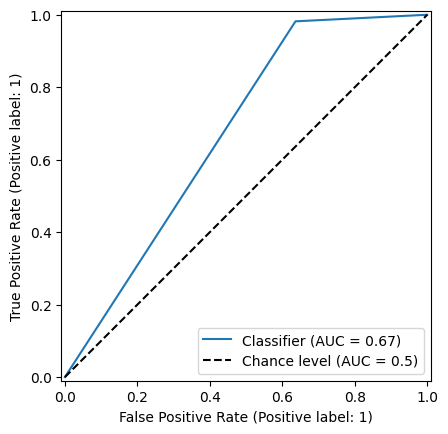

In [14]:
# ROC Curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_pred, plot_chance_level = True)

In [15]:
# Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[ 8, 14],
       [ 1, 54]], dtype=int64)

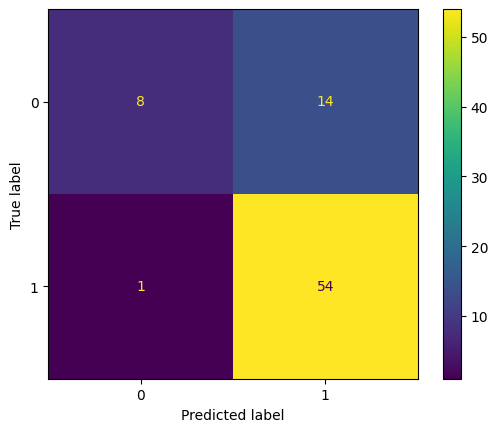

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), 
                       display_labels = logreg_best.classes_)
disp.plot()
plt.show()

The logistic regression model performed poorly to correctly predict the rejected loans. Plenty loans from the test set should have been rejected while they were approved (14 out of 22). We could say that the model is *over-approving*. This is also noticeable when looking at the true positives, that is, the loans predicted as approved which were actually approved (100%)
Moreover when testing different thresholds to make the model more rigurous, the precision reaches 0.8 and then falls rapidly. 

We should aim for a more conservative approach, that is, one that, at least, rejects more applications. 

### 2. Decision Tree Classifier
For the decision tree classifier we do not need to transform the data. We can simply use the original data

In [17]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 25)

cross_val_score(tree, X_train, y_train, cv = 10).mean()


0.7991397849462365

In [18]:
# Now let's aim for hyperparameter tunning
pipe = Pipeline([("classifier", DecisionTreeClassifier(random_state = 25))])

search_space = [
    {"classifier" : [DecisionTreeClassifier(random_state = 25)],
     "classifier__criterion" : ["gini", "entropy", "log_loss"],
     "classifier__ccp_alpha" : [0.0, 0.0001, 0.001, 0.01, 0.1, 1],
     "classifier__max_depth" : list(range(1,15))
    }
]

clf_tree = GridSearchCV(pipe, search_space, cv = 10, verbose = 1, n_jobs = -1, scoring = 'roc_auc')

In [19]:
clf_tree.fit(X_train, y_train)
print(clf_tree.best_estimator_.get_params()["classifier"])

Fitting 10 folds for each of 252 candidates, totalling 2520 fits
DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=25)


In [20]:
clf_tree.best_params_

{'classifier': DecisionTreeClassifier(random_state=25),
 'classifier__ccp_alpha': 0.0,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 6}

In [21]:
tree_best = DecisionTreeClassifier(random_state = 25, ccp_alpha = 0.0,
                                   max_depth = 6, criterion = 'entropy')#, class_weight = {0: 0.15, 1: 0.85})
tree_best.fit(X_train, y_train)

#tree_best.score(X_test, y_test)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=25)

In [22]:
# Check feature importance
feature_names = X_train.columns
feature_importances = pd.DataFrame(tree_best.feature_importances_, index = feature_names)
feature_importances.sort_values(by = [0], ascending = False)

,0
Credit_History_0.0,0.573736
CoapplicantIncome,0.109060
ApplicantIncome,0.061833
Property_Area_Semiurban,0.055030
Loan_Amount_Term,0.053767
LoanAmount,0.043877
Self_Employed_1,0.032638
Property_Area_Rural,0.024167
Dependents_3+,0.022432
Dependents_0,0.013874


Let's see what the tree looks like

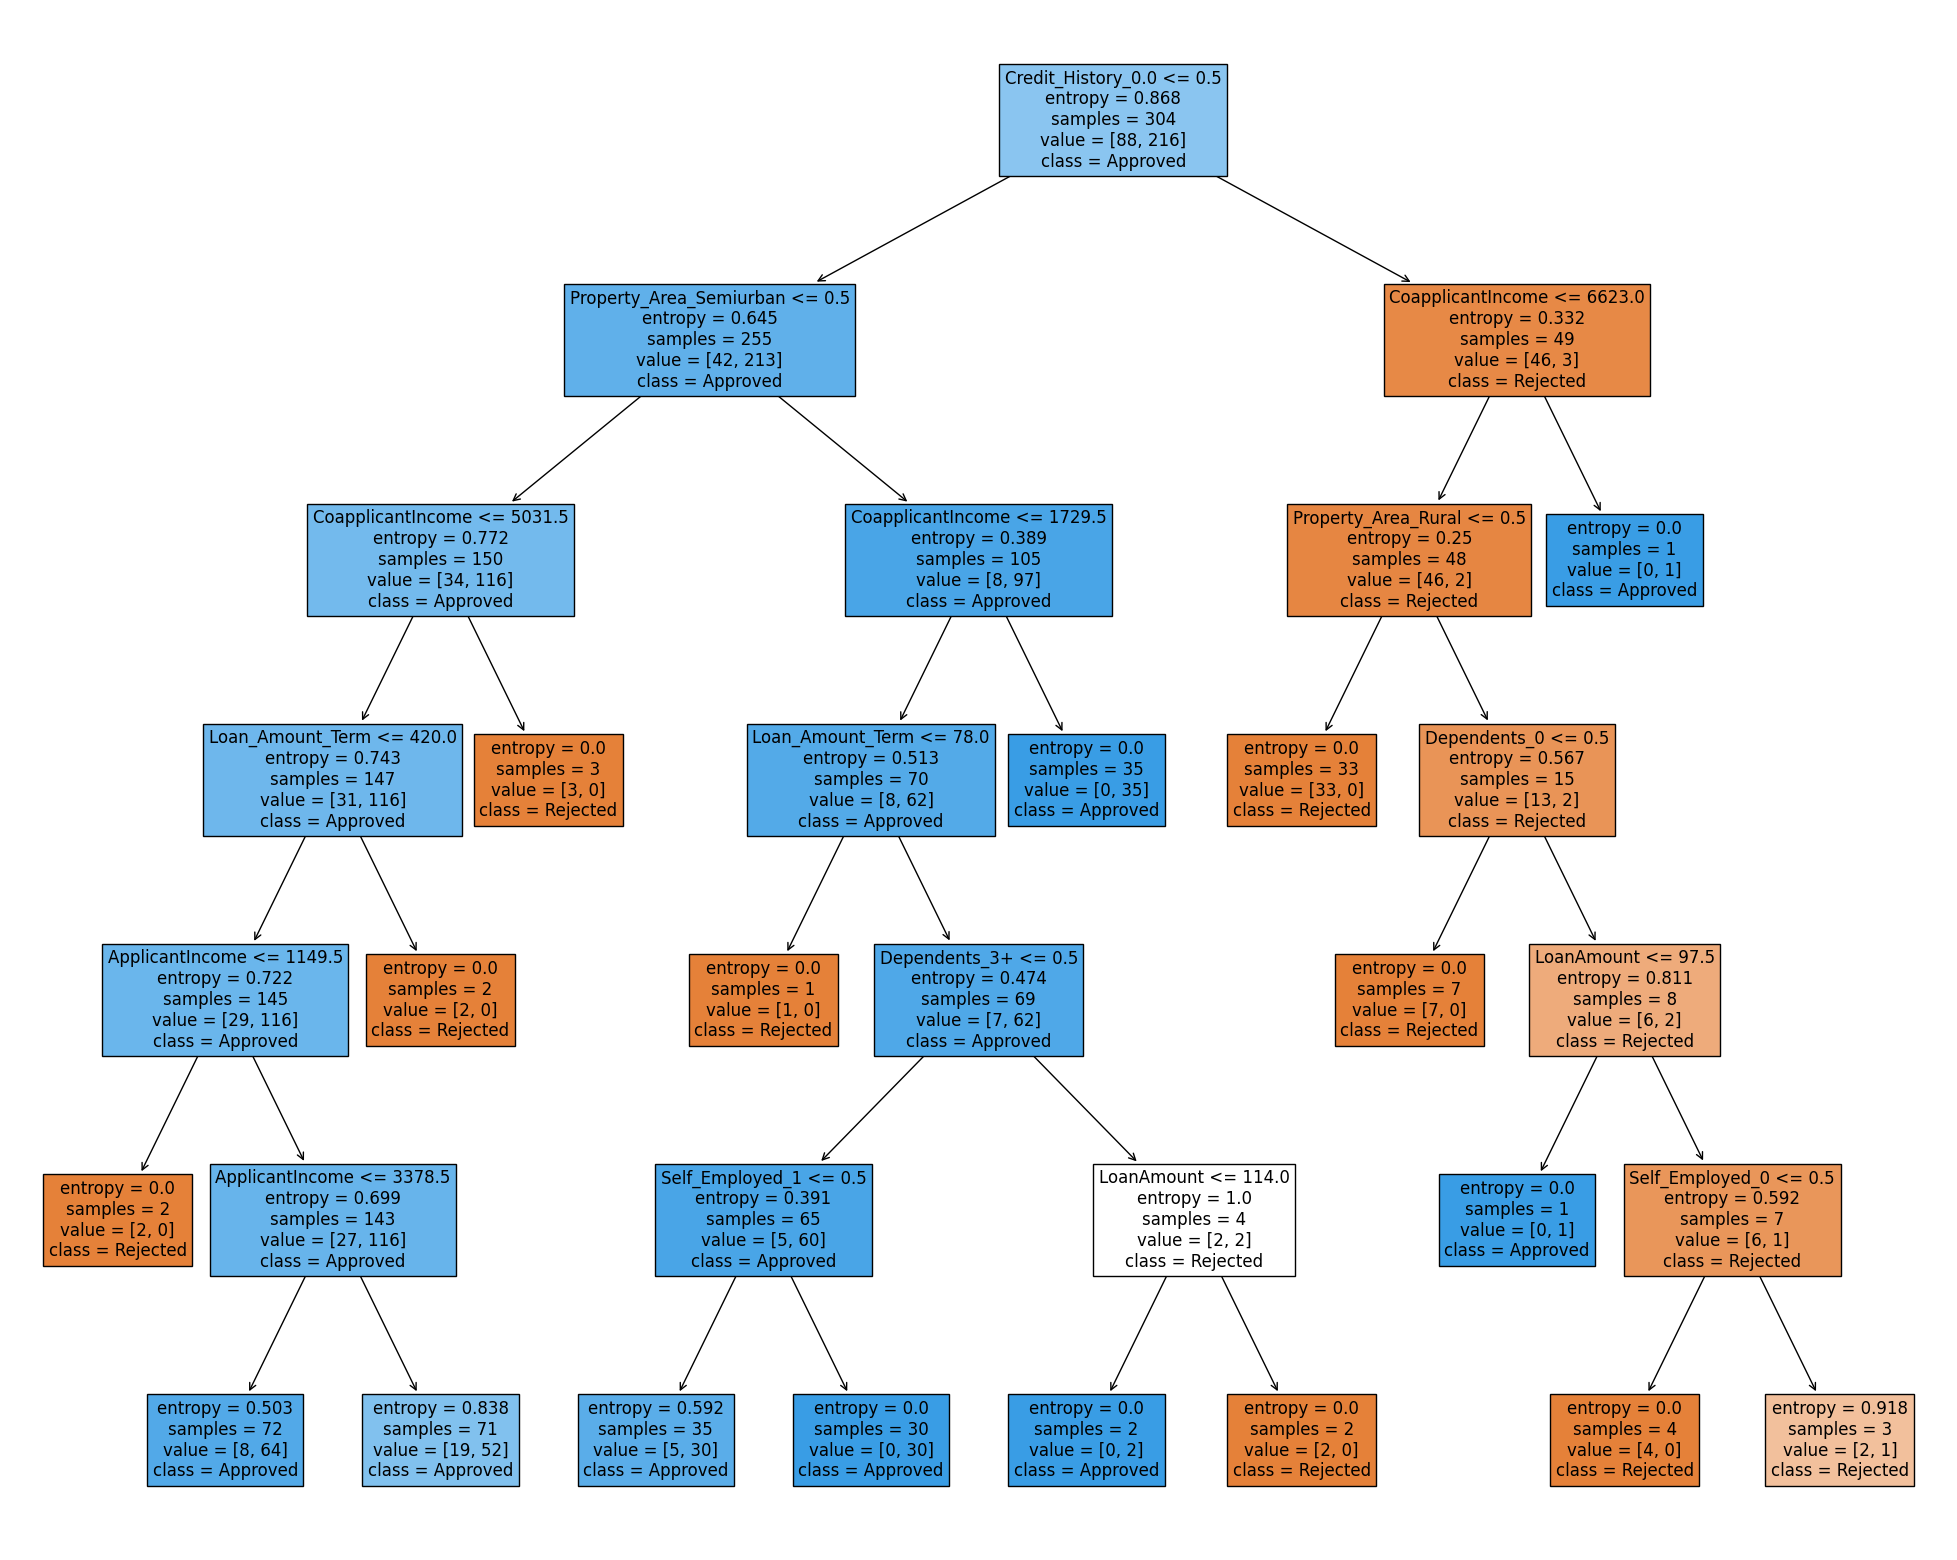

In [23]:
from sklearn import tree
fig = plt.figure(figsize = (25,20))
_ = tree.plot_tree(tree_best,
                   feature_names = feature_names,
                   class_names = {0 : 'Rejected', 1 : 'Approved'},
                   filled = True,
                   fontsize = 12)

In [24]:
# Make predictions on the test set
y_pred = tree_best.predict(X_test)
y_prob = tree_best.predict_proba(X_test)#[:, 1]

In [25]:
tree_precision_score = precision_score(y_test, y_pred)
tree_recall_score = recall_score(y_test, y_pred)
tree_roc_auc_score = roc_auc_score(y_test, y_pred)
tree_f1_score = f1_score(y_test, y_pred)

print('Decision tree presicion score: ' + str(round(tree_precision_score,3)))
print('Decision tree recall score: ' + str(round(tree_recall_score,3)))
print('Decision tree ROC score: ' + str(round(tree_roc_auc_score,3)))
print('Decision tree F1 score: ' + str(round(tree_f1_score,3)))

Decision tree presicion score: 0.788
Decision tree recall score: 0.945
Decision tree ROC score: 0.655
Decision tree F1 score: 0.86


(0.0, 1.0)

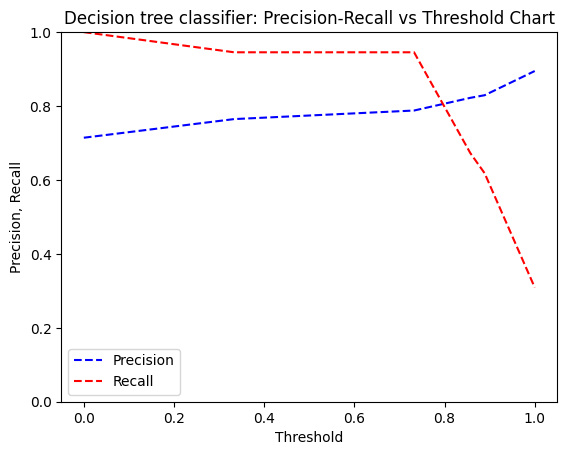

In [26]:
# Precision-Recall vs Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_prob [:,1]) 

plt.title("Decision tree classifier: Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

We actually aim for more precision, that is, better classification on positive values

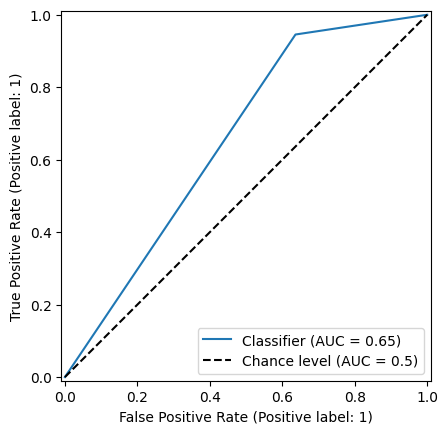

In [27]:
# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred, plot_chance_level = True)

In [28]:
# Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[ 8, 14],
       [ 3, 52]], dtype=int64)

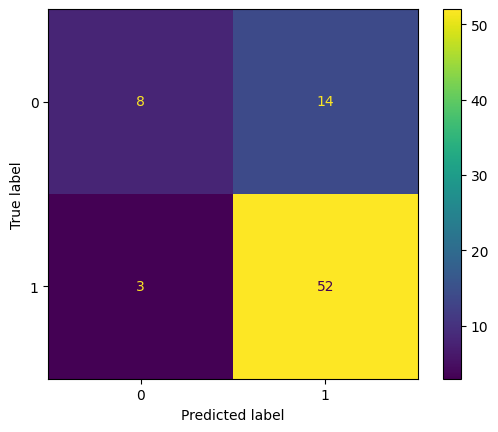

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), 
                       display_labels = logreg_best.classes_)
disp.plot()
plt.show()

The decision tree classifier had a poorer performance on classifying true positives

### 3. Random Forest Classifier
For the random forest classifier we do not need to transform the data. We can simply use the original data

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 25)

cross_val_score(rf, X_train, y_train, cv = 10).mean()


0.8382795698924731

In [31]:
# Now let's aim for hyperparameter tunning
pipe = Pipeline([("classifier", RandomForestClassifier(random_state = 25))])

search_space = [
    {"classifier" : [RandomForestClassifier(random_state = 25)],
     "classifier__criterion" : ["gini", "entropy", "log_loss"],
     "classifier__ccp_alpha" : [0.001, 0.01, 0.1, 1],
     "classifier__max_depth" : list(range(1,15))
    }
]

clf_rf = GridSearchCV(pipe, search_space, cv = 10, verbose = 1, n_jobs = -1, scoring = 'roc_auc')

In [32]:
clf_rf.fit(X_train, y_train)
print(clf_rf.best_estimator_.get_params()["classifier"])

Fitting 10 folds for each of 168 candidates, totalling 1680 fits
RandomForestClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=6,
                       random_state=25)


In [33]:
clf_rf.best_score_

0.8218554593554593

In [34]:
clf_rf.best_params_

{'classifier': RandomForestClassifier(random_state=25),
 'classifier__ccp_alpha': 0.001,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 6}

In [35]:
rf_best = DecisionTreeClassifier(random_state = 25, ccp_alpha = 0.001, 
                                 #lass_weight = {0: .25, 1: 0.75 },
                                 criterion = 'entropy', max_depth = 6)
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

rf_best.score(X_test, y_test)

0.7792207792207793

In [36]:
# Check feature importance
feature_names = X_train.columns
feature_importances = pd.DataFrame(rf_best.feature_importances_, index = feature_names)
feature_importances.sort_values(by = [0], ascending = False)

,0
Credit_History_0.0,0.573736
CoapplicantIncome,0.109060
ApplicantIncome,0.061833
Property_Area_Semiurban,0.055030
Loan_Amount_Term,0.053767
LoanAmount,0.043877
Self_Employed_1,0.032638
Property_Area_Rural,0.024167
Dependents_3+,0.022432
Dependents_0,0.013874


In [37]:
# Make predictions on the test set
y_pred = rf_best.predict(X_test)
y_prob = rf_best.predict_proba(X_test)#[:, 1]

In [38]:
rf_precision_score = precision_score(y_test, y_pred)
rf_recall_score = recall_score(y_test, y_pred)
rf_roc_auc_score = roc_auc_score(y_test, y_pred)
rf_f1_score = f1_score(y_test, y_pred)

print('Random forest presicion score: ' + str(round(rf_precision_score,3)))
print('Random forest recall score: ' + str(round(rf_recall_score,3)))
print('Random forest ROC score: ' + str(round(rf_roc_auc_score,3)))
print('Random forest F1 score: ' + str(round(rf_f1_score,3)))

Random forest presicion score: 0.788
Random forest recall score: 0.945
Random forest ROC score: 0.655
Random forest F1 score: 0.86


(0.0, 1.0)

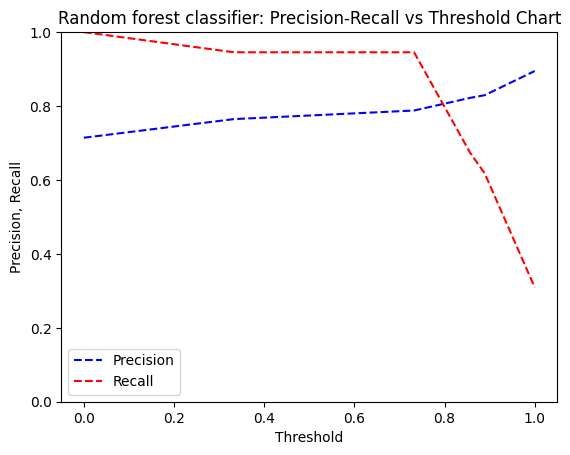

In [39]:
# Precision-Recall vs Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_prob [:,1]) 

plt.title("Random forest classifier: Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

We actually aim for more precision, that is, better classification on positive values

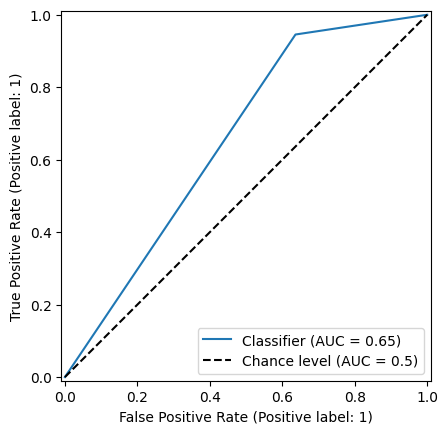

In [40]:
# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred, plot_chance_level = True)

In [41]:
# Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[ 8, 14],
       [ 3, 52]], dtype=int64)

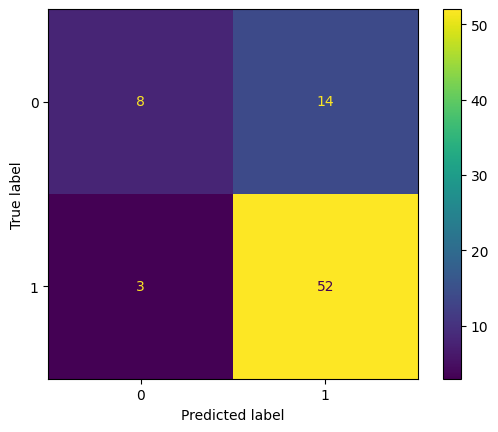

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), 
                       display_labels = logreg_best.classes_)
disp.plot()
plt.show()

The random forest classifier had the same performance at classifying as the decision tree.

### 4. Gradient Boosting Models
Gradient Boosting Models use weak learner classifiers and combine them to obtain a more powerful learner based on the pseudo-residuals obtained iteration after iteration. Most commonly used is the XGB classifier (eXtreme Gradient Boosting)

In [43]:
# Import XGBClassifier module from the xgboost library
from xgboost import XGBClassifier 

In [44]:
# Fit the initial model to the train data and evaluate its initial performance
xgb = XGBClassifier(random_state = 25)
xgb.fit(X_train, y_train)

xgb.score(X_test, y_test)

0.7662337662337663

In [45]:
# Fit the model using cross-validation
print(cross_val_score(xgb, X_train, y_train, cv = 25).mean())

0.8294871794871794


In [46]:
# Now let's aim for hyperparameter tunning
pipe = Pipeline([("classifier", XGBClassifier(random_state = 25))])

search_space = [
    {"classifier" : [XGBClassifier(random_state = 25)],
     "classifier__eta" : [0.1, 0.3, 0.5, 0.7, 1],
     "classifier__gamma" : [0, 0.1, 0.5, 1, 5, 10],
     "classifier__max_depth" : list(range(1,15)),
     
    }
]

clf_xgb = GridSearchCV(pipe, search_space, cv = 10, verbose = 3, n_jobs = -1)

In [47]:
clf_xgb.fit(X_train, y_train)
print(clf_xgb.best_estimator_.get_params()["classifier"])

Fitting 10 folds for each of 420 candidates, totalling 4200 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


In [48]:
clf_xgb.best_score_

0.8548387096774193

In [49]:
print(clf_xgb.best_params_)

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=25, ...), 'classifier__eta': 0.1, 'classifier__gamma': 1, 'classifier__max_depth': 3}


In [50]:
# Fit the model with the best set of hyperparameters and evaluate its performance
xgb_best = XGBClassifier(random_state = 25, eta = 0.1, gamma = 1, max_depth = 3)
xgb_best.fit(X_train, y_train)

print(xgb_best.score(X_test, y_test))

0.8181818181818182


In [51]:
# Make predictions on the test set
y_pred = xgb_best.predict(X_test)
y_prob = xgb_best.predict_proba(X_test)#[:, 1]

In [52]:
xgb_precision_score = precision_score(y_test, y_pred)
xgb_recall_score = recall_score(y_test, y_pred)
xgb_roc_auc_score = roc_auc_score(y_test, y_pred)
xgb_f1_score = f1_score(y_test, y_pred)

print('XGB presicion score: ' + str(round(xgb_precision_score,3)))
print('XGB recall score: ' + str(round(xgb_recall_score,3)))
print('XGB ROC score: ' + str(round(xgb_roc_auc_score,3)))
print('XGB F1 score: ' + str(round(xgb_f1_score,3)))

XGB presicion score: 0.797
XGB recall score: 1.0
XGB ROC score: 0.682
XGB F1 score: 0.887


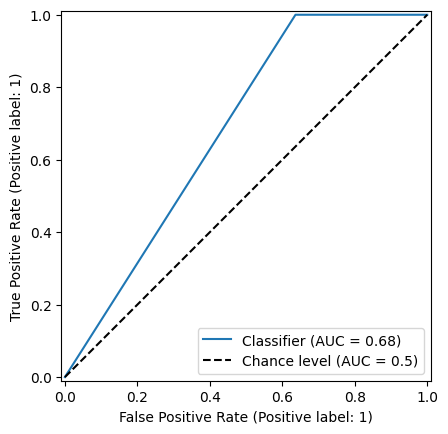

In [53]:
# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred, plot_chance_level = True)

In [54]:
# Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[ 8, 14],
       [ 0, 55]], dtype=int64)

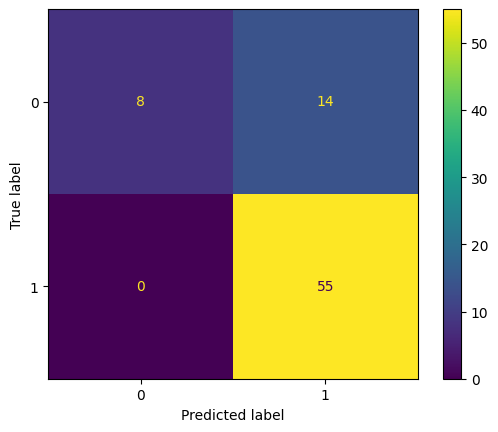

In [55]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), 
                       display_labels = xgb_best.classes_)
disp.plot()
plt.show()

The XGB classifier had a similar performance to the logistic regression model. The false positives rate is still a flaw with this model, but the true positives classification was perfect. 

### 5. Support Vector Machine
Support Vector Machine (SVM) uses support vector classifiers, that is, uses hyperplanes to maximise distances between groups of observations in a higher dimension hyperplane

In [56]:
from sklearn.svm import SVC #import the support vector classificator

In [57]:
# Fit the initial model to the train data and evaluate its initial performance
svc = SVC(random_state = 25)
svc.fit(X_n_train, y_train)

SVC(random_state=25)

In [58]:
svc.score(X_n_test, y_test)

0.8181818181818182

In [59]:
# Fit the model using cross-validation
print(cross_val_score(svc, X_n_train, y_train, cv = 25).mean())

0.8515384615384616


In [60]:
# Now let's aim for hyperparameter tunning
pipe = Pipeline([("classifier", SVC(random_state = 25))])

search_space = [
    {"classifier" : [SVC(random_state = 25)],
     "classifier__C" : [0.01, 0.1, 1, 10, 100, 1000],
     "classifier__gamma" : [ 0.001, 0.01, 0.1, 1, 10, 100]
    }
]

clf_svm = GridSearchCV(pipe, search_space, cv = 10, verbose = 3, n_jobs = -1)

In [61]:
clf_svm.fit(X_n_train, y_train)
print(clf_svm.best_estimator_.get_params()["classifier"])

Fitting 10 folds for each of 36 candidates, totalling 360 fits
SVC(C=1, gamma=0.01, random_state=25)


In [62]:
clf_svm.best_score_

0.8515053763440859

In [63]:
print(clf_svm.best_params_)

{'classifier': SVC(random_state=25), 'classifier__C': 1, 'classifier__gamma': 0.01}


In [64]:
# Fit the model with the best set of hyperparameters and evaluate its performance
svm_best = SVC(random_state = 25, C = 1, gamma = 0.01, probability = True)
svm_best.fit(X_n_train, y_train)

print(svm_best.score(X_n_test, y_test))

0.8181818181818182


In [65]:
# Make predictions on the test set
y_pred = svm_best.predict(X_n_test)
y_prob = svm_best.predict_proba(X_n_test)#[:, 1]

In [66]:
svm_precision_score = precision_score(y_test, y_pred)
svm_recall_score = recall_score(y_test, y_pred)
svm_roc_auc_score = roc_auc_score(y_test, y_pred)
svm_f1_score = f1_score(y_test, y_pred)

print('SVM presicion score: ' + str(round(svm_precision_score,3)))
print('SVM recall score: ' + str(round(svm_recall_score,3)))
print('SVM ROC score: ' + str(round(svm_roc_auc_score,3)))
print('SVM F1 score: ' + str(round(svm_f1_score,3)))

SVM presicion score: 0.797
SVM recall score: 1.0
SVM ROC score: 0.682
SVM F1 score: 0.887


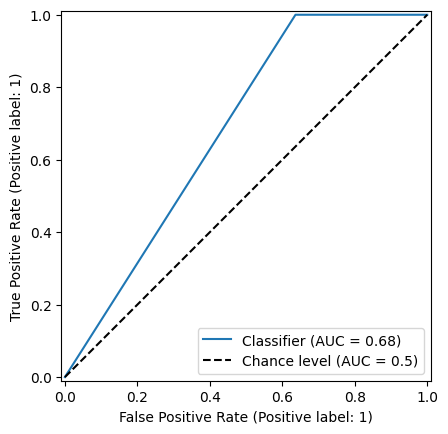

In [67]:
# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred, plot_chance_level = True)

In [68]:
# Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[ 8, 14],
       [ 0, 55]], dtype=int64)

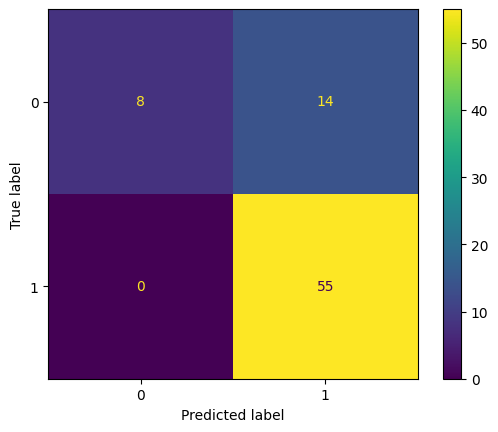

In [69]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), 
                       display_labels = svm_best.classes_)
disp.plot()
plt.show()

Same performance as the XGBClassifier

### 6. Neural Network
Multi-layer perceptron neural networks consist of a set of neurons (inputs) which are connected to sets of non-linear functions called hidden layers that return the output, in this case, to classify the data.

In [70]:
from sklearn.neural_network import MLPClassifier #import the MLP classifier

In [71]:
# Fit the initial model to the train data and evaluate its initial performance
mlp = MLPClassifier(random_state = 25, max_iter = 5000)

# MLPNN is sensitive to scaling and thus we will use the scaled data
mlp.fit(X_n_train, y_train)

MLPClassifier(max_iter=5000, random_state=25)

In [72]:
mlp.score(X_n_test, y_test)

0.7272727272727273

In [73]:
# Fit the model using cross-validation
print(cross_val_score(mlp, X_n_train, y_train, cv = 25).mean())

0.798974358974359


In [74]:
# Now let's aim for hyperparameter tunning
pipe = Pipeline([("classifier", MLPClassifier(random_state = 25))])

search_space = [
    {"classifier" : [MLPClassifier(random_state = 25)],
     "classifier__max_iter" : [200, 500, 1000, 1500, 2000, 2500],
     "classifier__hidden_layer_sizes" : [100, 150, 200, 250],
     "classifier__alpha" : 10.0 ** -np.arange(1, 7)
    }
]

clf_mlp = GridSearchCV(pipe, search_space, cv = 10, verbose = 3, n_jobs = -1)

In [75]:
clf_mlp.fit(X_n_train, y_train)
print(clf_mlp.best_estimator_.get_params()["classifier"])

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
MLPClassifier(alpha=0.1, hidden_layer_sizes=100, random_state=25)


C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [76]:
clf_mlp.best_score_

0.8482795698924731

In [77]:
print(clf_mlp.best_params_)

{'classifier': MLPClassifier(random_state=25), 'classifier__alpha': 0.1, 'classifier__hidden_layer_sizes': 100, 'classifier__max_iter': 200}


In [78]:
# Fit the model with the best set of hyperparameters and evaluate its performance
mlp_best = MLPClassifier(random_state = 25, alpha = 0.1, max_iter = 1500)
mlp_best.fit(X_n_train, y_train)

print(mlp_best.score(X_n_test, y_test))

0.7532467532467533


In [79]:
# Make predictions on the test set
y_pred = mlp_best.predict(X_n_test)
y_prob = mlp_best.predict_proba(X_n_test)#[:, 1]

In [80]:
mlp_precision_score = precision_score(y_test, y_pred)
mlp_recall_score = recall_score(y_test, y_pred)
mlp_roc_auc_score = roc_auc_score(y_test, y_pred)
mlp_f1_score = f1_score(y_test, y_pred)

print('MLP presicion score: ' + str(round(mlp_precision_score,3)))
print('MLP recall score: ' + str(round(mlp_recall_score,3)))
print('MLP ROC score: ' + str(round(mlp_roc_auc_score,3)))
print('MLP F1 score: ' + str(round(mlp_f1_score,3)))

MLP presicion score: 0.781
MLP recall score: 0.909
MLP ROC score: 0.636
MLP F1 score: 0.84


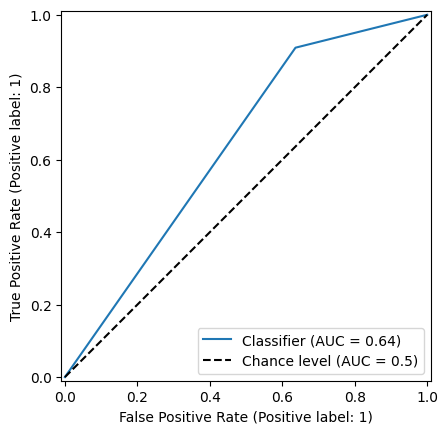

In [81]:
# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred, plot_chance_level = True)

In [82]:
# Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[ 8, 14],
       [ 5, 50]], dtype=int64)

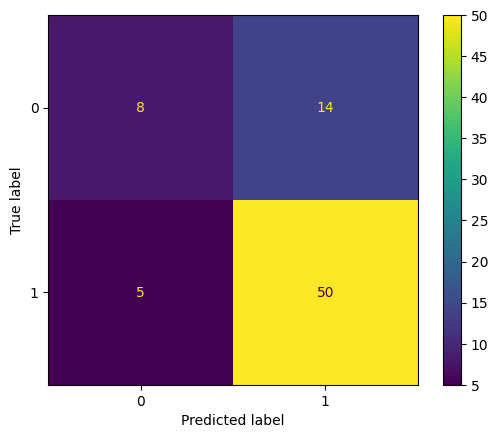

In [83]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), 
                       display_labels = svm_best.classes_)
disp.plot()
plt.show()

The MLP classifier had a poorer performance in predicting true positives

#### Best model
Best performing model was the Support Vector Machine, which had a ROC AUC score of 0.683. Additionally it perfectly predicted the true positives, that is it approved loans to applicants who were supposed to get approvals. It had a poor performance at predicting true negatives, that is, rejecting loans to applicants who were supposed to be rejected: 8 true negatives and 14 false negatives. The model tends to approve more loans than it should. This flaw does not correspond to the SVM only, but to all the other models. 